In [1]:
%matplotlib inline


## balancing samples in mini-batches with Keras


The data set is imbalanced and we show that balancing each mini-batch allows to improve performance and reduce the training
time.

### References
----------
.. [1] https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data




In [2]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

print(__doc__)

Automatically created module for IPython interactive environment


### Data loading

In [3]:
from collections import Counter
import pandas as pd
import numpy as np

In [6]:
filename=r'all_features.csv'
data = pd.read_csv(filename)
validation_data = pd.read_csv('./data for Richard/validation.csv')  # index column has the subset of entire dataset

In [133]:
data.columns

Index(['encounter_id', 'HbA1c_High_CH', 'HbA1c_High_NoCH', 'HbA1c_Norm',
       'diag1_collapse_circulatory', 'diag1_collapse_digestive',
       'diag1_collapse_genit', 'diag1_collapse_injury',
       'diag1_collapse_muscul', 'diag1_collapse_neoplasms',
       'diag1_collapse_other', 'diag1_collapse_respiratory', 'age_bin_60+',
       'age_bin_<30', 'medical_specialty_short_ER_trauma',
       'medical_specialty_short_gp', 'medical_specialty_short_inter_med',
       'medical_specialty_short_missing', 'medical_specialty_short_other',
       'medical_specialty_short_surgery', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'discharge_other',
       'admission_source_collapse_other', 'admission_source_collapse_referral',
       'admission_source_collapse_transfer', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_diagnoses', 'number_outpatient_log1p', 'number_emergency_log1p',
       'number_inpatient_log1p', 'readmi

In [10]:
validation_data.columns

Index(['index', 'encounter_id', 'HbA1c_High_CH', 'HbA1c_High_NoCH',
       'HbA1c_Norm', 'diag1_collapse_circulatory', 'diag1_collapse_digestive',
       'diag1_collapse_genit', 'diag1_collapse_injury',
       'diag1_collapse_muscul', 'diag1_collapse_neoplasms',
       'diag1_collapse_other', 'diag1_collapse_respiratory', 'age_bin_60+',
       'age_bin_<30', 'medical_specialty_short_ER_trauma',
       'medical_specialty_short_gp', 'medical_specialty_short_inter_med',
       'medical_specialty_short_missing', 'medical_specialty_short_other',
       'medical_specialty_short_surgery', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'discharge_other',
       'admission_source_collapse_other', 'admission_source_collapse_referral',
       'admission_source_collapse_transfer', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_diagnoses', 'number_outpatient_log1p', 'number_emergency_log1p',
       'number_inpatient_log1p'

In [95]:
train_index=list(set(data.index) - set(validation_data.index))
train_data=data.loc[train_index]

y_train = train_data['readmitted_yes']
X_train = train_data.iloc[:,1:data.shape[1]-1]
y_val = validation_data['readmitted_yes']
X_val = validation_data.iloc[:, 2:validation_data.shape[1]-1]

In [96]:
print(X_train.shape)
print(X_val.shape)

(61657, 35)
(6851, 35)


In [201]:
print(sum(y_val)) # obtain the total number of patients that are readmitted 
print(sum(y_val)/len(y_val))

636
0.0928331630418917


The data set is imbalanced and it will have an effect on the fitting.



In [20]:
print('The data set is imbalanced: {}'.format(Counter(y_train)))

The data set is imbalanced: Counter({0: 56176, 1: 5481})


Define the pre-processing pipeline
##############################################################################



In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

In [220]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score # do not save over auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, precision_recall_curve, f1_score

We want to standard scale the numerical features while we want to one-hot
encode the categorical features. In this regard, we make use of the
:class:`sklearn.compose.ColumnTransformer`.



numerical_columns = [name for name in X_train.columns if '_calc_' in name and '_bin' not in name]

numerical_pipeline = make_pipeline(
    FunctionTransformer(func=convert_float64, validate=False),
    StandardScaler())

categorical_columns = [name for name in X_train.columns if '_cat' in name]

categorical_pipeline = make_pipeline(
    SimpleImputer(missing_values=-1, strategy='most_frequent'),
    OneHotEncoder(categories='auto'))

preprocessor = ColumnTransformer(
    [('numerical_preprocessing', numerical_pipeline, numerical_columns),
     ('categorical_preprocessing', categorical_pipeline, categorical_columns)],
    remainder='drop')

In [22]:
def convert_float64(X):
    return X.astype(np.float64)

In [189]:
numerical_columns= ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications','number_diagnoses', 'number_outpatient_log1p', 'number_emergency_log1p','number_inpatient_log1p']

cat_columns=['HbA1c_High_CH', 'HbA1c_High_NoCH', 'HbA1c_Norm',
       'diag1_collapse_circulatory', 'diag1_collapse_digestive',
       'diag1_collapse_genit', 'diag1_collapse_injury',
       'diag1_collapse_muscul', 'diag1_collapse_neoplasms',
       'diag1_collapse_other', 'diag1_collapse_respiratory', 'age_bin_60+',
       'age_bin_<30', 'medical_specialty_short_ER_trauma',
       'medical_specialty_short_gp', 'medical_specialty_short_inter_med',
       'medical_specialty_short_missing', 'medical_specialty_short_other',
       'medical_specialty_short_surgery', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'discharge_other',
       'admission_source_collapse_other', 'admission_source_collapse_referral',
       'admission_source_collapse_transfer']


numerical_pipeline = make_pipeline(
    FunctionTransformer(func=convert_float64, validate=False),
    StandardScaler())

cat_pipeline = make_pipeline(
    FunctionTransformer(func=convert_float64, validate=False))
    #StandardScaler())

preprocessor = ColumnTransformer(
    [('numerical_preprocessing', numerical_pipeline, numerical_columns),
    ('cat_preprocessing', cat_pipeline, cat_columns)
    ])

preprocessor2 = ColumnTransformer(   # use numerical variables only 
    [('numerical_preprocessing', numerical_pipeline, numerical_columns)
    ])

In [25]:
# Create an environment variable to avoid using the GPU. This can be changed.
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

### Create a neural-network

In [93]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization


def make_model(n_features):
    model = Sequential()
    model.add(Dense(1500, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))  
    model.add(Dropout(0.5))
    model.add(Dense(1500, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1500, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(1500, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',  
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

We create a decorator to report the computation time



In [27]:
import time
from functools import wraps


def timeit(f):
    @wraps(f)
    def wrapper(*args, **kwds):
        start_time = time.time()
        result = f(*args, **kwds)
        elapsed_time = time.time() - start_time
        print('Elapsed computation time: {:.3f} secs'
              .format(elapsed_time))
        return (elapsed_time, result)
    return wrapper

#### we will use imbalanced-learn to create a generator of mini-batches which will yield balanced mini-batches.

In [41]:
from imblearn.keras import BalancedBatchGenerator

@timeit
def fit_predict_balanced_model(X_train, y_train, X_val, y_val):
    X_train= preprocessor.fit_transform(X_train)
    model = make_model(X_train.shape[1])
    training_generator = BalancedBatchGenerator(X_train, y_train,
                                                batch_size=500,
                                                random_state=42)
    model.fit_generator(generator=training_generator, epochs=10, verbose=1)
    X_val= preprocessor.fit_transform(X_val)
    y_pred = model.predict_proba(X_val, batch_size=500)[:,-1]
    return roc_auc_score(y_val, y_pred)

In [42]:
auc=fit_predict_balanced_model(X_train, y_train, X_val, y_val)

Epoch 1/10
21/21 [==============================] - 4s 191ms/step - loss: 0.7334 - accuracy: 0.5335
Epoch 2/10
21/21 [==============================] - 2s 78ms/step - loss: 0.6974 - accuracy: 0.5473
Epoch 3/10
21/21 [==============================] - 2s 74ms/step - loss: 0.6884 - accuracy: 0.5565
Epoch 4/10
21/21 [==============================] - 2s 77ms/step - loss: 0.6856 - accuracy: 0.5627
Epoch 5/10
21/21 [==============================] - 2s 78ms/step - loss: 0.6860 - accuracy: 0.5545
Epoch 6/10
21/21 [==============================] - 2s 83ms/step - loss: 0.6862 - accuracy: 0.5601
Epoch 7/10
21/21 [==============================] - 2s 77ms/step - loss: 0.6859 - accuracy: 0.5578
Epoch 8/10
21/21 [==============================] - 2s 77ms/step - loss: 0.6823 - accuracy: 0.5611
Epoch 9/10
21/21 [==============================] - 2s 81ms/step - loss: 0.6781 - accuracy: 0.5770
Epoch 10/10
21/21 [==============================] - 2s 85ms/step - loss: 0.6790 - accuracy: 0.5695
Elapsed 

In [117]:
model = make_model(preprocessor2.fit_transform(X_train).shape[1])
training_generator = BalancedBatchGenerator(preprocessor2.fit_transform(X_train), y_train,batch_size=500, random_state=42)
model.fit_generator(generator=training_generator, epochs=1000, verbose=1)

Epoch 1/1000
21/21 [==============================] - 19s 890ms/step - loss: 0.9544 - accuracy: 0.5171
Epoch 2/1000
21/21 [==============================] - 13s 618ms/step - loss: 0.7275 - accuracy: 0.5344
Epoch 3/1000
21/21 [==============================] - 13s 621ms/step - loss: 0.7044 - accuracy: 0.5548
Epoch 4/1000
21/21 [==============================] - 13s 618ms/step - loss: 0.6944 - accuracy: 0.5574
Epoch 5/1000
21/21 [==============================] - 13s 611ms/step - loss: 0.6847 - accuracy: 0.5629
Epoch 6/1000
21/21 [==============================] - 13s 614ms/step - loss: 0.6881 - accuracy: 0.5617
Epoch 7/1000
21/21 [==============================] - 13s 614ms/step - loss: 0.6861 - accuracy: 0.5609
Epoch 8/1000
21/21 [==============================] - 13s 617ms/step - loss: 0.6870 - accuracy: 0.5627
Epoch 9/1000
21/21 [==============================] - 13s 610ms/step - loss: 0.6849 - accuracy: 0.5645
Epoch 10/1000
21/21 [==============================] - 13s 616ms/step - l

21/21 [==============================] - 13s 637ms/step - loss: 0.6560 - accuracy: 0.6046
Epoch 80/1000
21/21 [==============================] - 14s 646ms/step - loss: 0.6518 - accuracy: 0.6124
Epoch 81/1000
21/21 [==============================] - 13s 629ms/step - loss: 0.6485 - accuracy: 0.6123
Epoch 82/1000
21/21 [==============================] - 13s 637ms/step - loss: 0.6487 - accuracy: 0.6134
Epoch 83/1000
21/21 [==============================] - 14s 646ms/step - loss: 0.6485 - accuracy: 0.6178
Epoch 84/1000
21/21 [==============================] - 13s 637ms/step - loss: 0.6496 - accuracy: 0.6108
Epoch 85/1000
21/21 [==============================] - 14s 643ms/step - loss: 0.6476 - accuracy: 0.6123
Epoch 86/1000
21/21 [==============================] - 14s 644ms/step - loss: 0.6486 - accuracy: 0.6162
Epoch 87/1000
21/21 [==============================] - 13s 630ms/step - loss: 0.6473 - accuracy: 0.6151
Epoch 88/1000
21/21 [==============================] - 13s 636ms/step - loss: 

21/21 [==============================] - 13s 632ms/step - loss: 0.5993 - accuracy: 0.6659
Epoch 158/1000
21/21 [==============================] - 13s 628ms/step - loss: 0.6034 - accuracy: 0.6614
Epoch 159/1000
21/21 [==============================] - 13s 632ms/step - loss: 0.6009 - accuracy: 0.6625
Epoch 160/1000
21/21 [==============================] - 13s 641ms/step - loss: 0.6013 - accuracy: 0.6624
Epoch 161/1000
21/21 [==============================] - 13s 636ms/step - loss: 0.6014 - accuracy: 0.6644
Epoch 162/1000
21/21 [==============================] - 13s 633ms/step - loss: 0.5992 - accuracy: 0.6657
Epoch 163/1000
21/21 [==============================] - 13s 626ms/step - loss: 0.5969 - accuracy: 0.6685
Epoch 164/1000
21/21 [==============================] - 13s 636ms/step - loss: 0.5966 - accuracy: 0.6615
Epoch 165/1000
21/21 [==============================] - 13s 638ms/step - loss: 0.5975 - accuracy: 0.6662
Epoch 166/1000
21/21 [==============================] - 13s 627ms/step

21/21 [==============================] - 13s 629ms/step - loss: 0.5269 - accuracy: 0.7233
Epoch 236/1000
21/21 [==============================] - 13s 630ms/step - loss: 0.5240 - accuracy: 0.7230
Epoch 237/1000
21/21 [==============================] - 13s 637ms/step - loss: 0.5203 - accuracy: 0.7258
Epoch 238/1000
21/21 [==============================] - 13s 633ms/step - loss: 0.5230 - accuracy: 0.7238
Epoch 239/1000
21/21 [==============================] - 13s 638ms/step - loss: 0.5234 - accuracy: 0.7252
Epoch 240/1000
21/21 [==============================] - 13s 629ms/step - loss: 0.5143 - accuracy: 0.7258
Epoch 241/1000
21/21 [==============================] - 13s 638ms/step - loss: 0.5255 - accuracy: 0.7195
Epoch 242/1000
21/21 [==============================] - 13s 633ms/step - loss: 0.5146 - accuracy: 0.7333
Epoch 243/1000
21/21 [==============================] - 13s 635ms/step - loss: 0.5164 - accuracy: 0.7259
Epoch 244/1000
21/21 [==============================] - 13s 636ms/step

21/21 [==============================] - 13s 627ms/step - loss: 0.4336 - accuracy: 0.7830
Epoch 314/1000
21/21 [==============================] - 13s 641ms/step - loss: 0.4351 - accuracy: 0.7803
Epoch 315/1000
21/21 [==============================] - 14s 643ms/step - loss: 0.4365 - accuracy: 0.7790
Epoch 316/1000
21/21 [==============================] - 13s 621ms/step - loss: 0.4355 - accuracy: 0.7830
Epoch 317/1000
21/21 [==============================] - 13s 629ms/step - loss: 0.4293 - accuracy: 0.7833
Epoch 318/1000
21/21 [==============================] - 13s 632ms/step - loss: 0.4278 - accuracy: 0.7883
Epoch 319/1000
21/21 [==============================] - 13s 635ms/step - loss: 0.4283 - accuracy: 0.7855
Epoch 320/1000
21/21 [==============================] - 13s 630ms/step - loss: 0.4363 - accuracy: 0.7841
Epoch 321/1000
21/21 [==============================] - 14s 647ms/step - loss: 0.4270 - accuracy: 0.7867
Epoch 322/1000
21/21 [==============================] - 14s 652ms/step

21/21 [==============================] - 14s 659ms/step - loss: 0.3614 - accuracy: 0.8241
Epoch 392/1000
21/21 [==============================] - 14s 649ms/step - loss: 0.3624 - accuracy: 0.8242
Epoch 393/1000
21/21 [==============================] - 14s 655ms/step - loss: 0.3520 - accuracy: 0.8313
Epoch 394/1000
21/21 [==============================] - 14s 649ms/step - loss: 0.3488 - accuracy: 0.8334
Epoch 395/1000
21/21 [==============================] - 14s 665ms/step - loss: 0.3528 - accuracy: 0.8313
Epoch 396/1000
21/21 [==============================] - 14s 654ms/step - loss: 0.3467 - accuracy: 0.8353
Epoch 397/1000
21/21 [==============================] - 14s 678ms/step - loss: 0.3462 - accuracy: 0.8334
Epoch 398/1000
21/21 [==============================] - 13s 640ms/step - loss: 0.3537 - accuracy: 0.8328
Epoch 399/1000
21/21 [==============================] - 13s 636ms/step - loss: 0.3494 - accuracy: 0.8355
Epoch 400/1000
21/21 [==============================] - 13s 635ms/step

21/21 [==============================] - 13s 624ms/step - loss: 0.2777 - accuracy: 0.8751
Epoch 470/1000
21/21 [==============================] - 13s 638ms/step - loss: 0.2860 - accuracy: 0.8701
Epoch 471/1000
21/21 [==============================] - 13s 633ms/step - loss: 0.2839 - accuracy: 0.8763
Epoch 472/1000
21/21 [==============================] - 13s 631ms/step - loss: 0.2668 - accuracy: 0.8809
Epoch 473/1000
21/21 [==============================] - 13s 634ms/step - loss: 0.2754 - accuracy: 0.8760
Epoch 474/1000
21/21 [==============================] - 14s 644ms/step - loss: 0.2711 - accuracy: 0.8782
Epoch 475/1000
21/21 [==============================] - 13s 622ms/step - loss: 0.2658 - accuracy: 0.8832
Epoch 476/1000
21/21 [==============================] - 13s 627ms/step - loss: 0.2676 - accuracy: 0.8810
Epoch 477/1000
21/21 [==============================] - 13s 634ms/step - loss: 0.2686 - accuracy: 0.8796
Epoch 478/1000
21/21 [==============================] - 13s 631ms/step

21/21 [==============================] - 15s 699ms/step - loss: 0.2108 - accuracy: 0.9104
Epoch 548/1000
21/21 [==============================] - 15s 702ms/step - loss: 0.2008 - accuracy: 0.9137
Epoch 549/1000
21/21 [==============================] - 15s 699ms/step - loss: 0.2065 - accuracy: 0.9140
Epoch 550/1000
21/21 [==============================] - 15s 697ms/step - loss: 0.2046 - accuracy: 0.9155
Epoch 551/1000
21/21 [==============================] - 15s 694ms/step - loss: 0.2030 - accuracy: 0.9142
Epoch 552/1000
21/21 [==============================] - 15s 707ms/step - loss: 0.1995 - accuracy: 0.9179
Epoch 553/1000
21/21 [==============================] - 15s 698ms/step - loss: 0.1984 - accuracy: 0.9173
Epoch 554/1000
21/21 [==============================] - 15s 695ms/step - loss: 0.2030 - accuracy: 0.9162
Epoch 555/1000
21/21 [==============================] - 14s 689ms/step - loss: 0.1981 - accuracy: 0.9179
Epoch 556/1000
21/21 [==============================] - 18s 847ms/step

21/21 [==============================] - 13s 632ms/step - loss: 0.1716 - accuracy: 0.9302
Epoch 626/1000
21/21 [==============================] - 14s 646ms/step - loss: 0.1738 - accuracy: 0.9320
Epoch 627/1000
21/21 [==============================] - 13s 633ms/step - loss: 0.1612 - accuracy: 0.9389
Epoch 628/1000
21/21 [==============================] - 13s 637ms/step - loss: 0.1457 - accuracy: 0.9452
Epoch 629/1000
21/21 [==============================] - 13s 632ms/step - loss: 0.1547 - accuracy: 0.9416
Epoch 630/1000
21/21 [==============================] - 13s 627ms/step - loss: 0.1476 - accuracy: 0.9415
Epoch 631/1000
21/21 [==============================] - 13s 624ms/step - loss: 0.1537 - accuracy: 0.9407
Epoch 632/1000
21/21 [==============================] - 13s 640ms/step - loss: 0.1445 - accuracy: 0.9448
Epoch 633/1000
21/21 [==============================] - 13s 641ms/step - loss: 0.1446 - accuracy: 0.9432
Epoch 634/1000
21/21 [==============================] - 13s 633ms/step

21/21 [==============================] - 13s 638ms/step - loss: 0.1078 - accuracy: 0.9602
Epoch 704/1000
21/21 [==============================] - 14s 653ms/step - loss: 0.1082 - accuracy: 0.9586
Epoch 705/1000
21/21 [==============================] - 14s 664ms/step - loss: 0.1068 - accuracy: 0.9618
Epoch 706/1000
21/21 [==============================] - 13s 628ms/step - loss: 0.1079 - accuracy: 0.9601
Epoch 707/1000
21/21 [==============================] - 13s 639ms/step - loss: 0.1075 - accuracy: 0.9592
Epoch 708/1000
21/21 [==============================] - 13s 630ms/step - loss: 0.1119 - accuracy: 0.9577
Epoch 709/1000
21/21 [==============================] - 14s 647ms/step - loss: 0.1086 - accuracy: 0.9597
Epoch 710/1000
21/21 [==============================] - 13s 642ms/step - loss: 0.1130 - accuracy: 0.9573
Epoch 711/1000
21/21 [==============================] - 13s 633ms/step - loss: 0.1122 - accuracy: 0.9594
Epoch 712/1000
21/21 [==============================] - 13s 635ms/step

21/21 [==============================] - 13s 633ms/step - loss: 0.0933 - accuracy: 0.9664
Epoch 782/1000
21/21 [==============================] - 13s 636ms/step - loss: 0.1010 - accuracy: 0.9655
Epoch 783/1000
21/21 [==============================] - 13s 639ms/step - loss: 0.0880 - accuracy: 0.9700
Epoch 784/1000
21/21 [==============================] - 13s 634ms/step - loss: 0.0836 - accuracy: 0.9720
Epoch 785/1000
21/21 [==============================] - 13s 636ms/step - loss: 0.0827 - accuracy: 0.9695
Epoch 786/1000
21/21 [==============================] - 13s 626ms/step - loss: 0.0895 - accuracy: 0.9682
Epoch 787/1000
21/21 [==============================] - 13s 634ms/step - loss: 0.0832 - accuracy: 0.9705
Epoch 788/1000
21/21 [==============================] - 13s 637ms/step - loss: 0.0860 - accuracy: 0.9692
Epoch 789/1000
21/21 [==============================] - 13s 632ms/step - loss: 0.0873 - accuracy: 0.9687
Epoch 790/1000
21/21 [==============================] - 13s 635ms/step

21/21 [==============================] - 13s 636ms/step - loss: 0.0831 - accuracy: 0.9746
Epoch 860/1000
21/21 [==============================] - 13s 632ms/step - loss: 0.0833 - accuracy: 0.9743
Epoch 861/1000
21/21 [==============================] - 13s 625ms/step - loss: 0.0809 - accuracy: 0.9756
Epoch 862/1000
21/21 [==============================] - 13s 628ms/step - loss: 0.0765 - accuracy: 0.9741
Epoch 863/1000
21/21 [==============================] - 13s 629ms/step - loss: 0.0779 - accuracy: 0.9726
Epoch 864/1000
21/21 [==============================] - 13s 635ms/step - loss: 0.0749 - accuracy: 0.9733
Epoch 865/1000
21/21 [==============================] - 13s 636ms/step - loss: 0.0704 - accuracy: 0.9737
Epoch 866/1000
21/21 [==============================] - 14s 644ms/step - loss: 0.0687 - accuracy: 0.9761
Epoch 867/1000
21/21 [==============================] - 13s 628ms/step - loss: 0.0694 - accuracy: 0.9753
Epoch 868/1000
21/21 [==============================] - 13s 635ms/step

21/21 [==============================] - 14s 655ms/step - loss: 0.0638 - accuracy: 0.9796
Epoch 938/1000
21/21 [==============================] - 14s 659ms/step - loss: 0.0565 - accuracy: 0.9809
Epoch 939/1000
21/21 [==============================] - 14s 663ms/step - loss: 0.0541 - accuracy: 0.9808
Epoch 940/1000
21/21 [==============================] - 14s 653ms/step - loss: 0.0608 - accuracy: 0.9783
Epoch 941/1000
21/21 [==============================] - 18s 850ms/step - loss: 0.0532 - accuracy: 0.9802
Epoch 942/1000
21/21 [==============================] - 16s 778ms/step - loss: 0.0513 - accuracy: 0.9826
Epoch 943/1000
21/21 [==============================] - 16s 764ms/step - loss: 0.0504 - accuracy: 0.9812
Epoch 944/1000
21/21 [==============================] - 15s 714ms/step - loss: 0.0588 - accuracy: 0.9795
Epoch 945/1000
21/21 [==============================] - 14s 647ms/step - loss: 0.0510 - accuracy: 0.9830
Epoch 946/1000
21/21 [==============================] - 14s 647ms/step

In [168]:
y_pred = model.predict_proba(preprocessor2.fit_transform(X_val))[:,-1]
auc = roc_auc_score(y_val, y_pred)
avg_precision= average_precision_score(y_val, y_pred)

In [163]:
print(auc)
print(avg_precision)

0.7408459701371706
0.21997052282146345


In [172]:
y_pred_score= model.predict_classes(preprocessor2.fit_transform(X_val))
cm=confusion_matrix(y_val, y_pred_score)
cm

array([[3382, 2833],
       [ 126,  510]], dtype=int64)

In [165]:
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_score).ravel()
(tn, fp, fn, tp)
specificity= tn/(tn+fp)
print(specificity)
sensitivity= tp/(tp+fn)
print(sensitivity)
precision= tp/(tp+fp)
print(precision)

0.544167337087691

### Plot Model Results:

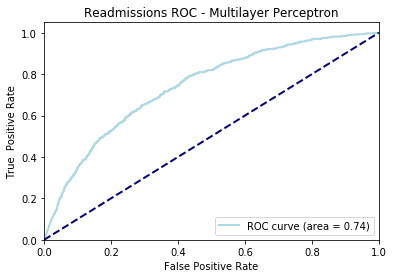

In [171]:
fpr, tpr, treshold = roc_curve(y_val, y_pred, pos_label=1)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='lightblue',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)  # auc is already calculated from above
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True  Positive Rate')
plt.title('Readmissions ROC - Multilayer Perceptron')
plt.legend(loc='lower right')
plt.show()

Logistic: f1=0.256 auc=0.251


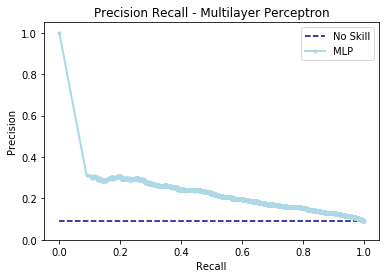

In [187]:
# keep probabilities for the positive outcome only
lr_probs = y_pred
# predict class values
yhat = y_pred_score
lr_precision, lr_recall, _ = precision_recall_curve(y_val, lr_probs)
lr_f1, lr_auc = f1_score(y_val, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill', color = 'navy')
plt.plot(lr_recall, lr_precision, marker='.', label='MLP', color = "lightblue", lw = 2)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall - Multilayer Perceptron')
plt.ylim([0.0, 1.05])
# show the legend
plt.legend()
# show the plot
plt.show()

### Save results and Model

In [124]:
np.savez_compressed('val_prob_val_y', a= y_pred, b=y_val)

In [126]:
loaded=np.load('model results for Charlie/val_prob_val_y.npz')
loaded.files

In [132]:
import pickle
# save the model to disk
filename = 'NeuralNetwork.sav'
pickle.dump(model, open(filename, 'wb'))

In [125]:
np.savetxt("y_pred.csv", y_pred, delimiter=",")
np.savetxt("y_val.csv", y_val, delimiter=",")

#### ENSEMBLE 

In [112]:
pred1 = model1.predict( val )
pred2 = model2.predict( val )
pred3 = model3.predict( val )
pred = np.sum( pred1 + pred2 + pred3 )>= 2

NameError: name 'model1' is not defined

### Second Model: Do not scale categorical data 

In [190]:
model2 = make_model(preprocessor.fit_transform(X_train).shape[1])
training_generator = BalancedBatchGenerator(preprocessor.fit_transform(X_train), y_train,batch_size=500, random_state=42)
model2.fit_generator(generator=training_generator, epochs=200, verbose=1)

Epoch 1/200
21/21 [==============================] - 14s 662ms/step - loss: 0.8558 - accuracy: 0.5404
Epoch 2/200
21/21 [==============================] - 12s 555ms/step - loss: 0.7576 - accuracy: 0.5561
Epoch 3/200
21/21 [==============================] - 11s 534ms/step - loss: 0.7065 - accuracy: 0.5673
Epoch 4/200
21/21 [==============================] - 11s 535ms/step - loss: 0.6786 - accuracy: 0.5852
Epoch 5/200
21/21 [==============================] - 12s 555ms/step - loss: 0.6677 - accuracy: 0.6041
Epoch 6/200
21/21 [==============================] - 11s 541ms/step - loss: 0.6688 - accuracy: 0.5993
Epoch 7/200
21/21 [==============================] - 12s 556ms/step - loss: 0.6594 - accuracy: 0.6155
Epoch 8/200
21/21 [==============================] - 12s 562ms/step - loss: 0.6594 - accuracy: 0.6140
Epoch 9/200
21/21 [==============================] - 12s 580ms/step - loss: 0.6542 - accuracy: 0.6170
Epoch 10/200
21/21 [==============================] - 12s 566ms/step - loss: 0.657

21/21 [==============================] - 14s 655ms/step - loss: 0.3524 - accuracy: 0.8361
Epoch 81/200
21/21 [==============================] - 14s 654ms/step - loss: 0.3534 - accuracy: 0.8372
Epoch 82/200
21/21 [==============================] - 14s 670ms/step - loss: 0.3392 - accuracy: 0.8420
Epoch 83/200
21/21 [==============================] - 14s 659ms/step - loss: 0.3435 - accuracy: 0.8407
Epoch 84/200
21/21 [==============================] - 14s 667ms/step - loss: 0.3422 - accuracy: 0.8430
Epoch 85/200
21/21 [==============================] - 14s 658ms/step - loss: 0.3394 - accuracy: 0.8438
Epoch 86/200
21/21 [==============================] - 14s 664ms/step - loss: 0.3214 - accuracy: 0.8567
Epoch 87/200
21/21 [==============================] - 14s 673ms/step - loss: 0.3165 - accuracy: 0.8529
Epoch 88/200
21/21 [==============================] - 14s 672ms/step - loss: 0.3217 - accuracy: 0.8564
Epoch 89/200
21/21 [==============================] - 14s 682ms/step - loss: 0.3155 - 

21/21 [==============================] - 14s 659ms/step - loss: 0.1577 - accuracy: 0.9338
Epoch 160/200
21/21 [==============================] - 14s 651ms/step - loss: 0.1471 - accuracy: 0.9394
Epoch 161/200
21/21 [==============================] - 13s 635ms/step - loss: 0.1563 - accuracy: 0.9334
Epoch 162/200
21/21 [==============================] - 13s 630ms/step - loss: 0.1503 - accuracy: 0.9370
Epoch 163/200
21/21 [==============================] - 13s 640ms/step - loss: 0.1584 - accuracy: 0.9336
Epoch 164/200
21/21 [==============================] - 14s 652ms/step - loss: 0.1480 - accuracy: 0.9415
Epoch 165/200
21/21 [==============================] - 14s 645ms/step - loss: 0.1481 - accuracy: 0.9390
Epoch 166/200
21/21 [==============================] - 13s 632ms/step - loss: 0.1485 - accuracy: 0.9390
Epoch 167/200
21/21 [==============================] - 13s 641ms/step - loss: 0.1346 - accuracy: 0.9415
Epoch 168/200
21/21 [==============================] - 13s 640ms/step - loss: 

In [202]:
model3 = make_model(preprocessor.fit_transform(X_train).shape[1])
training_generator = BalancedBatchGenerator(preprocessor.fit_transform(X_train), y_train,batch_size=500, random_state=42)
model3.fit_generator(generator=training_generator, epochs=400, verbose=1)

Epoch 1/400
21/21 [==============================] - 14s 672ms/step - loss: 0.9028 - accuracy: 0.5354
Epoch 2/400
21/21 [==============================] - 11s 527ms/step - loss: 0.7595 - accuracy: 0.5542
Epoch 3/400
21/21 [==============================] - 12s 553ms/step - loss: 0.7028 - accuracy: 0.5622
Epoch 4/400
21/21 [==============================] - 12s 565ms/step - loss: 0.6854 - accuracy: 0.5853
Epoch 5/400
21/21 [==============================] - 12s 578ms/step - loss: 0.6748 - accuracy: 0.5971
Epoch 6/400
21/21 [==============================] - 12s 561ms/step - loss: 0.6693 - accuracy: 0.6003
Epoch 7/400
21/21 [==============================] - 12s 567ms/step - loss: 0.6593 - accuracy: 0.6158
Epoch 8/400
21/21 [==============================] - 12s 556ms/step - loss: 0.6572 - accuracy: 0.6169
Epoch 9/400
21/21 [==============================] - 12s 553ms/step - loss: 0.6541 - accuracy: 0.6181
Epoch 10/400
21/21 [==============================] - 12s 564ms/step - loss: 0.649

21/21 [==============================] - 14s 685ms/step - loss: 0.3423 - accuracy: 0.8433
Epoch 81/400
21/21 [==============================] - 14s 681ms/step - loss: 0.3335 - accuracy: 0.8472
Epoch 82/400
21/21 [==============================] - 14s 677ms/step - loss: 0.3326 - accuracy: 0.8453
Epoch 83/400
21/21 [==============================] - 14s 650ms/step - loss: 0.3340 - accuracy: 0.8456
Epoch 84/400
21/21 [==============================] - 13s 637ms/step - loss: 0.3234 - accuracy: 0.8500
Epoch 85/400
21/21 [==============================] - 13s 640ms/step - loss: 0.3207 - accuracy: 0.8508
Epoch 86/400
21/21 [==============================] - 13s 635ms/step - loss: 0.3206 - accuracy: 0.8563
Epoch 87/400
21/21 [==============================] - 15s 697ms/step - loss: 0.3144 - accuracy: 0.8523
Epoch 88/400
21/21 [==============================] - 13s 636ms/step - loss: 0.3196 - accuracy: 0.8499
Epoch 89/400
21/21 [==============================] - 13s 632ms/step - loss: 0.3041 - 

21/21 [==============================] - 13s 634ms/step - loss: 0.1576 - accuracy: 0.9330
Epoch 160/400
21/21 [==============================] - 13s 636ms/step - loss: 0.1656 - accuracy: 0.9287
Epoch 161/400
21/21 [==============================] - 14s 648ms/step - loss: 0.1537 - accuracy: 0.9384
Epoch 162/400
21/21 [==============================] - 14s 644ms/step - loss: 0.1475 - accuracy: 0.9386
Epoch 163/400
21/21 [==============================] - 14s 660ms/step - loss: 0.1385 - accuracy: 0.9418
Epoch 164/400
21/21 [==============================] - 14s 647ms/step - loss: 0.1324 - accuracy: 0.9443
Epoch 165/400
21/21 [==============================] - 14s 648ms/step - loss: 0.1396 - accuracy: 0.9410
Epoch 166/400
21/21 [==============================] - 14s 658ms/step - loss: 0.1390 - accuracy: 0.9411
Epoch 167/400
21/21 [==============================] - 14s 656ms/step - loss: 0.1435 - accuracy: 0.9423
Epoch 168/400
21/21 [==============================] - 14s 657ms/step - loss: 

21/21 [==============================] - 14s 668ms/step - loss: 0.0935 - accuracy: 0.9637
Epoch 238/400
21/21 [==============================] - 15s 711ms/step - loss: 0.0880 - accuracy: 0.9650
Epoch 239/400
21/21 [==============================] - 15s 706ms/step - loss: 0.0865 - accuracy: 0.9658
Epoch 240/400
21/21 [==============================] - 14s 655ms/step - loss: 0.0836 - accuracy: 0.9679
Epoch 241/400
21/21 [==============================] - 14s 654ms/step - loss: 0.0835 - accuracy: 0.9677
Epoch 242/400
21/21 [==============================] - 13s 623ms/step - loss: 0.0885 - accuracy: 0.9688
Epoch 243/400
21/21 [==============================] - 14s 644ms/step - loss: 0.0838 - accuracy: 0.9657
Epoch 244/400
21/21 [==============================] - 14s 644ms/step - loss: 0.0835 - accuracy: 0.9680
Epoch 245/400
21/21 [==============================] - 15s 695ms/step - loss: 0.0852 - accuracy: 0.9664
Epoch 246/400
21/21 [==============================] - 14s 649ms/step - loss: 

21/21 [==============================] - 14s 680ms/step - loss: 0.0600 - accuracy: 0.9772
Epoch 316/400
21/21 [==============================] - 14s 675ms/step - loss: 0.0552 - accuracy: 0.9807
Epoch 317/400
21/21 [==============================] - 14s 679ms/step - loss: 0.0591 - accuracy: 0.9805
Epoch 318/400
21/21 [==============================] - 16s 766ms/step - loss: 0.0585 - accuracy: 0.9792
Epoch 319/400
21/21 [==============================] - 15s 720ms/step - loss: 0.0671 - accuracy: 0.9753
Epoch 320/400
21/21 [==============================] - 16s 765ms/step - loss: 0.0632 - accuracy: 0.9770
Epoch 321/400
21/21 [==============================] - 17s 798ms/step - loss: 0.0613 - accuracy: 0.9770
Epoch 322/400
21/21 [==============================] - 15s 729ms/step - loss: 0.0588 - accuracy: 0.9770
Epoch 323/400
21/21 [==============================] - 13s 642ms/step - loss: 0.0598 - accuracy: 0.9776
Epoch 324/400
21/21 [==============================] - 14s 675ms/step - loss: 

21/21 [==============================] - 13s 627ms/step - loss: 0.0439 - accuracy: 0.9830
Epoch 394/400
21/21 [==============================] - 13s 627ms/step - loss: 0.0488 - accuracy: 0.9813
Epoch 395/400
21/21 [==============================] - 13s 627ms/step - loss: 0.0452 - accuracy: 0.9829
Epoch 396/400
21/21 [==============================] - 13s 627ms/step - loss: 0.0464 - accuracy: 0.9847
Epoch 397/400
21/21 [==============================] - 13s 629ms/step - loss: 0.0480 - accuracy: 0.9822
Epoch 398/400
21/21 [==============================] - 15s 697ms/step - loss: 0.0468 - accuracy: 0.9827
Epoch 399/400
21/21 [==============================] - 13s 633ms/step - loss: 0.0490 - accuracy: 0.9825
Epoch 400/400
21/21 [==============================] - 13s 629ms/step - loss: 0.0506 - accuracy: 0.9817


In [203]:
y_pred3 = model3.predict_proba(preprocessor.fit_transform(X_val))[:,-1]
auc = roc_auc_score(y_val, y_pred3)
avg_precision= average_precision_score(y_val, y_pred3)

In [204]:
print(auc)
print(avg_precision)

0.8545202821334063
0.33772329547674573


In [209]:
y_pred_score3= model3.predict_classes(preprocessor.fit_transform(X_val))
cm=confusion_matrix(y_val, y_pred_score3)
cm

array([[3525, 2690],
       [  43,  593]], dtype=int64)

In [206]:
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_score3).ravel()
print(tn, fp, fn, tp)
specificity= tn/(tn+fp)
print(specificity)
sensitivity= tp/(tp+fn)
print(sensitivity)
precision= tp/(tp+fp)
print(precision)

3525 2690 43 593
0.5671761866452132
0.9323899371069182
0.18062747487054523


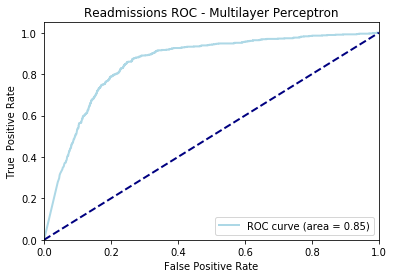

In [221]:
fpr, tpr, threshold = roc_curve(y_val, y_pred3, pos_label=1)
auc_plot= auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='lightblue',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_plot)  # auc is already calculated from above
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True  Positive Rate')
plt.title('Readmissions ROC - Multilayer Perceptron')
plt.legend(loc='lower right')
plt.show()

In [232]:
auc(fpr, tpr)

0.8545202821334063

mlp: auc=0.406


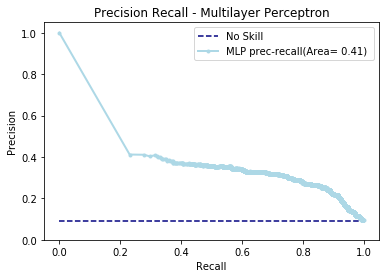

In [229]:
# keep probabilities for the positive outcome only
probs = y_pred3
# predict class values
yhat = y_pred_score3
precision, recall, thresholds = precision_recall_curve(y_val, probs)
f1= f1_score(y_val, yhat)
auc_plot = auc(recall, precision)
# summarize scores
print('mlp: auc=%.3f' % (auc_plot))
# plot the precision-recall curves
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill', color = 'navy')
plt.plot(recall, precision, marker='.', label='MLP prec-recall(Area= %.2f) '% auc_plot, color = "lightblue", lw = 2)
# axis labels
#plt.plot(recall, precision,  label= "prec-recall(Area= %.2f)" % auc_plot)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall - Multilayer Perceptron')
plt.ylim([0.0, 1.05])
# show the legend
plt.legend()
# show the plot
plt.show()

In [230]:
np.savez_compressed('val_prob_val_y_2', a= y_pred3, b=y_val)

In [231]:
# save the model to disk
filename = 'NeuralNetwork2.sav'
pickle.dump(model3, open(filename, 'wb'))

In [237]:
predictions=pd.DataFrame(data=y_pred3, index=validation_data.index, columns='prob_readmitted')
prange,bins = pd.qcut(predictions['prob_readmitted'],10,retbins=True)

bins[0]  -= 0.001
bins[-1] += 0.001

bins_labels = ['%d.(%0.2f,%0.2f]'%(x[0],x[1][0],x[1][1]) for x in enumerate(zip(bins[:-1],bins[1:]))]
bins_labels[0]                 = bins_labels[0].replace('(','[')

predictions['Decile']          = pd.cut(predictions['prob_readmitted'],bins=bins,labels=bins_labels)
predictions['Patients']        = 1
predictions['Not_Readmitted']  = 1-predictions['readmitted']
predictions['Readmitted']      =   predictions['readmitted']
predictions['Prob_Min']        = prange.apply(lambda x : x.left)
predictions['Prob_Max']        = prange.apply(lambda x : x.right)
    
summary  = predictions.groupby(['Decile'])[['Readmitted','Not_Readmitted','Patients','Prob_Min','Prob_Max']].sum()
# summary['Prob_MinMax'] = ['%0.2f - %0.2f'%(x[1][0],x[1][1]) for x in enumerate(zip(bins[:-1],bins[1:]))]
summary['Prob_Min']    = [x for x in bins[:-1]]
summary['Prob_Max']    = [x for x in bins[1: ]]

summary  = summary.sort_index(ascending=False)

    
summary['ReadmittedRate_pct']  =summary['Readmitted']/summary['Patients']
summary['Lift'] = (summary['Readmitted']/summary['Patients'])/.10
summary

TypeError: Index(...) must be called with a collection of some kind, 'prob_readmitted' was passed

Classification loop
##############################################################################



We will perform a 10-fold cross-validation and train the neural-network with
the two different strategies previously presented.



In [34]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10)

cv_results_imbalanced = []
cv_time_imbalanced = []
cv_results_balanced = []
cv_time_balanced = []

for train_idx, valid_idx in skf.split(X_train, y_train):
    X_local_train = preprocessor.fit_transform(X_train.iloc[train_idx])
    y_local_train = y_train.iloc[train_idx].values.ravel()
    X_local_test = preprocessor.transform(X_train.iloc[valid_idx])
    y_local_test = y_train.iloc[valid_idx].values.ravel()

    elapsed_time, roc_auc = fit_predict_imbalanced_model(
        X_local_train, y_local_train, X_local_test, y_local_test)
    cv_time_imbalanced.append(elapsed_time)
    cv_results_imbalanced.append(roc_auc)

    elapsed_time, roc_auc = fit_predict_balanced_model(
        X_local_train, y_local_train, X_local_test, y_local_test)
    cv_time_balanced.append(elapsed_time)
    cv_results_balanced.append(roc_auc)

Epoch 1/20
55491/55491 [==============================] - 10s 187us/step - loss: 0.4246 - accuracy: 0.8613
Epoch 2/20
55491/55491 [==============================] - 8s 142us/step - loss: 0.3104 - accuracy: 0.9101
Epoch 3/20
55491/55491 [==============================] - 8s 142us/step - loss: 0.3023 - accuracy: 0.9108
Epoch 4/20
55491/55491 [==============================] - 8s 140us/step - loss: 0.3014 - accuracy: 0.9108
Epoch 5/20
55491/55491 [==============================] - 8s 148us/step - loss: 0.3000 - accuracy: 0.9110
Epoch 6/20
55491/55491 [==============================] - 8s 143us/step - loss: 0.3001 - accuracy: 0.9110
Epoch 7/20
55491/55491 [==============================] - 8s 147us/step - loss: 0.2989 - accuracy: 0.9109
Epoch 8/20
55491/55491 [==============================] - 8s 148us/step - loss: 0.2993 - accuracy: 0.9109
Epoch 9/20
55491/55491 [==============================] - 8s 151us/step - loss: 0.2986 - accuracy: 0.9111
Epoch 10/20
55491/55491 [====================

9/9 [==============================] - 2s 175ms/step - loss: 0.6763 - accuracy: 0.57011s - loss: 0.6779 - accu
Epoch 20/20
9/9 [==============================] - 1s 162ms/step - loss: 0.6746 - accuracy: 0.5769
Elapsed computation time: 39.916 secs
Epoch 1/20
55491/55491 [==============================] - 13s 226us/step - loss: 0.6143 - accuracy: 0.7043s - loss: 0.6
Epoch 2/20
55491/55491 [==============================] - 9s 170us/step - loss: 0.3436 - accuracy: 0.9068
Epoch 3/20
55491/55491 [==============================] - 10s 172us/step - loss: 0.3118 - accuracy: 0.9093
Epoch 4/20
55491/55491 [==============================] - 10s 178us/step - loss: 0.3048 - accuracy: 0.9096
Epoch 5/20
55491/55491 [==============================] - 9s 171us/step - loss: 0.3032 - accuracy: 0.9101
Epoch 6/20
55491/55491 [==============================] - 10s 175us/step - loss: 0.3023 - accuracy: 0.9100
Epoch 7/20
55491/55491 [==============================] - 9s 167us/step - loss: 0.3021 - accuracy: 

9/9 [==============================] - 1s 166ms/step - loss: 0.6851 - accuracy: 0.5629
Epoch 15/20
9/9 [==============================] - 2s 186ms/step - loss: 0.6859 - accuracy: 0.5612
Epoch 16/20
9/9 [==============================] - 2s 170ms/step - loss: 0.6811 - accuracy: 0.5720
Epoch 17/20
9/9 [==============================] - 2s 167ms/step - loss: 0.6809 - accuracy: 0.5709
Epoch 18/20
9/9 [==============================] - 2s 169ms/step - loss: 0.6816 - accuracy: 0.5652
Epoch 19/20
9/9 [==============================] - 2s 196ms/step - loss: 0.6814 - accuracy: 0.5654
Epoch 20/20
9/9 [==============================] - 2s 169ms/step - loss: 0.6768 - accuracy: 0.5729
Elapsed computation time: 40.818 secs
Epoch 1/20
55491/55491 [==============================] - 13s 227us/step - loss: 0.5158 - accuracy: 0.7921
Epoch 2/20
55491/55491 [==============================] - 10s 173us/step - loss: 0.3262 - accuracy: 0.9088
Epoch 3/20
55491/55491 [==============================] - 10s 178us

9/9 [==============================] - 2s 168ms/step - loss: 0.6774 - accuracy: 0.5750
Epoch 12/20
9/9 [==============================] - 2s 170ms/step - loss: 0.6815 - accuracy: 0.5663
Epoch 13/20
9/9 [==============================] - 2s 184ms/step - loss: 0.6820 - accuracy: 0.5659
Epoch 14/20
9/9 [==============================] - 2s 170ms/step - loss: 0.6810 - accuracy: 0.5684
Epoch 15/20
9/9 [==============================] - 2s 174ms/step - loss: 0.6783 - accuracy: 0.5713
Epoch 16/20
9/9 [==============================] - 2s 172ms/step - loss: 0.6793 - accuracy: 0.5708
Epoch 17/20
9/9 [==============================] - 2s 182ms/step - loss: 0.6801 - accuracy: 0.5691
Epoch 18/20
9/9 [==============================] - 2s 176ms/step - loss: 0.6770 - accuracy: 0.57401s - loss: 0.6773 - accu
Epoch 19/20
9/9 [==============================] - 1s 167ms/step - loss: 0.6774 - accuracy: 0.5659
Epoch 20/20
9/9 [==============================] - 2s 171ms/step - loss: 0.6735 - accuracy: 0.580

KeyboardInterrupt: 